In [1]:
import os
import pandas as pd
import chardet
import numpy as np
from scipy.constants import R

# Указываем строку, с которой начинается чтение данных
SRART_ROW = 36  # Нумерация с нуля, поэтому 36 строка в файле - это индекс 35

# Указываем название элемента, с которым хотим работать
ELEMENT = 'Dy'

# Какие скорости нагрева представленны в экспериментальных данных и в каком порядке
# в градус/минута
heating_rates = ['3', '10', '5']

# Указываем названия колонок
column_names = ['temperature'] + heating_rates

# Указываем путь к папке
folder_path = "TGA"

# Получаем все файлы в указанной папке
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Проверяем, есть ли файлы в списке
if not file_list:
    raise Exception("No files found in the specified directory.")
    
# Выбираем первый файл из списка
tga_file = [file for file in file_list if file.startswith(ELEMENT)]


# Определяем кодировку файла
with open(os.path.join(folder_path, tga_file[0]), 'rb') as f:
    result = chardet.detect(f.read())
file_encoding = result['encoding']

# Считывание данных из CSV файла
df = pd.read_csv(
    os.path.join(folder_path, tga_file[0]),
    skiprows=SRART_ROW,
    names=column_names,
    delimiter=';',
    decimal=',',
    encoding=file_encoding,
    dtype=str  # Прочитать все данные как строки
)

# Замена запятых на точки и преобразование в числа
df = df.apply(lambda x: pd.to_numeric(x.str.replace(',', '.'), errors='coerce'))

# Удаление строк с NaN значениями
df.dropna(inplace=True)

# Устанавливаем колонку 'temperature' в качестве индекса
df.set_index('temperature', inplace=True)

# Сортировка столбцов DataFrame по heating_rates
heating_rates.sort(key=int)  # сортировка элементов списка как целых чисел
df = df[heating_rates]  # переупорядочивание столбцов DataFrame

# Вывод первых пяти строк данных
df.head()

,3,5,10
temperature,,,
31.63192,99.99894,100.07588,99.96317
32.58683,99.99902,100.04476,99.97090
33.54175,100.00064,100.03758,99.97650
34.49666,100.00060,100.03165,99.98113
35.45158,99.99498,100.03084,99.97782


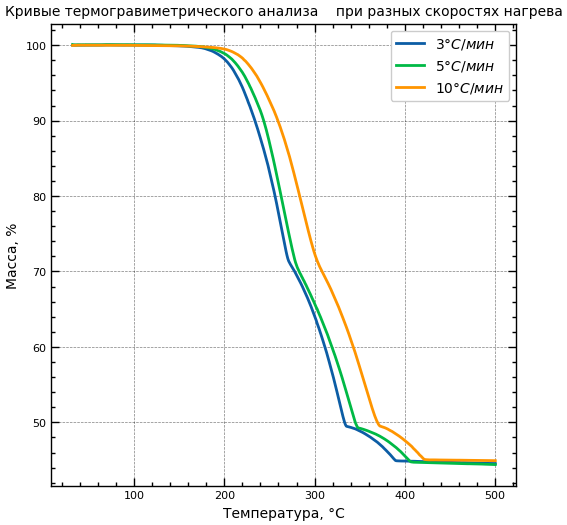

In [2]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex', 'notebook', 'grid'])

# задаём константы для графиков
BIG_SIZE = 12
MEDIUM_SIZE = 10
SMALL_SIZE = 8

# Создаём фигуру 
fig, axes = plt.subplots(figsize=(6, 6))

axes.plot(df.index, df['3'], label=r'$3°C/мин$')
axes.plot(df.index, df['5'], label=r'$5°C/мин$')
axes.plot(df.index, df['10'], label=r'$10°C/мин$')

# Добавляем подписи на оси
axes.set_xlabel('Температура, °С', fontsize=MEDIUM_SIZE)
axes.set_ylabel('Масса, %', fontsize=MEDIUM_SIZE)
# Добавляем заголовок
axes.set_title('Кривые термогравиметрического анализа\
    при разных скоростях нагрева', 
               fontsize=MEDIUM_SIZE)
# Настраиваем размер легенды и подписей осей
axes.legend(loc='upper right', fontsize=MEDIUM_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

plt.show()

Кинетику твердофазных реакций можно изучать с помощью термических аналитических методов путем измерения свойств образца при нагреве или при постоянной температуре. Если реакция связана с потерей массы, то масса отслеживается на протяжении реакции, и кинетика обычно изучается с помощью термогравиметрии (ТГА). Тепловой эффект (выделяющийся или поглощаемый) - это еще одно измеряемое свойство, которое используется для кинетической оценки с использованием дифференциальной сканирующей калориметрии (ДСК) или дифференциального термического анализа (ДТА). Данные о потере массы или потоке тепла преобразуются в нормализованную форму, называемую степенью превращения ($\alpha$). Степень превращения варьирует от 0 до 1 и является мерой прогресса реакции в зависимости от времени или температуры.

Для изотермического термогравиметрического анализа доля превращения в любой момент времени определяется следующим образом:

$$ \alpha = \frac{{m_0 - m_t}}{{m_0 - m_{\infty}}} ~~(1)$$

где:
$ m_0 $ - начальная масса образца,
 $ m_t $ - масса образца в момент времени $ t $, 
 $ m_{\infty} $ - конечная масса образца.


In [3]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df['3'], name=r'$3°C/мин$'))
fig.add_trace(go.Scatter(x=df.index, y=df['5'], name=r'$5°C/мин$'))
fig.add_trace(go.Scatter(x=df.index, y=df['10'], name=r'$10°C/мин$'))

fig.update_layout(
xaxis=dict(title='Температура, °С'),
yaxis=dict(title='Масса, %'),
title=dict(text='Кривые термогравиметрического анализа\
    при разных скоростях нагрева')
)

fig.update_layout(
legend=dict(
x=1,
y=1,
traceorder="normal",
font=dict(size=10)
),
xaxis_tickfont=dict(size=8),
yaxis_tickfont=dict(size=8)
)

fig.show()

Находим температуры при которых заканчиваются одни реакции и начинаются другие

,start,peak_1,peak_2,peak_3,end
3,181.55357,271.31558,335.3,390.67996,415.50775
5,189.19289,277.99999,347.7,406.91351,431.74130
10,204.47153,299.96303,372.5,422.19215,447.01994


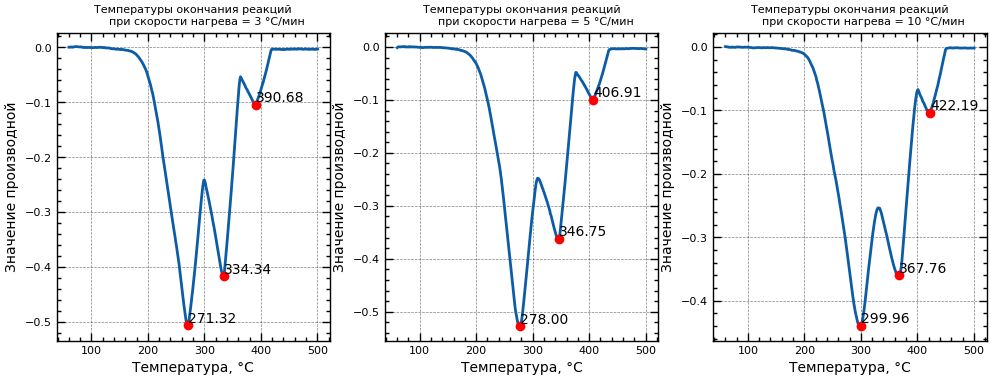

In [4]:
# Определяем значение отсекающее хвосты экспериментов
DIFF_PEAK_CONST = -0.015

# Определение размера окна для сглаживания
window_size = 30

def find_peaks(df):
    positive_mask = df > 0
    positive_after_negative_mask = (
        positive_mask & (~positive_mask.shift(1, fill_value=True)))
    return df[positive_after_negative_mask]

# Инициализация датафрейма с границами начала и конца реакций
peaks_df = pd.DataFrame()

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

for idx, heating_rate in enumerate(heating_rates):
    # Сглаживание данных с использованием скользящего среднего
    smoothed_df = df[heating_rate].rolling(window_size).mean()

    # Расчет дифференциала (первой производной) для сглаженных данных
    diff_df = smoothed_df.diff()   

    # Находим температуры при которых реакции начинаются и заканчиваются
    t_start = diff_df[diff_df < DIFF_PEAK_CONST].index.min()
    t_end = diff_df[diff_df < DIFF_PEAK_CONST].index.max()

    # Находим температуры пиков по второй производной
    peaks = find_peaks(
        diff_df[(diff_df.index > t_start) & (diff_df.index < t_end)].diff())

    # Обновляем столбцы в датафрейме для каждого heating_rate и заполняем NaN
    columns = ['start'] + [f'peak_{i+1}' for i in range(len(peaks))] + ['end']
    for column in columns:
        if column not in peaks_df.columns:
            peaks_df[column] = np.nan

    peaks_df.at[heating_rate, 'start'] = t_start
    peaks_df.at[heating_rate, 'end'] = t_end
    for i, peak in enumerate(peaks.index):
        peaks_df.at[heating_rate, f'peak_{i+1}'] = peak

    axes[idx].plot(df.index, diff_df)

    # Добавляем заголовок
    axes[idx].set_title(f'Температуры окончания реакций\n\
        при скорости нагрева = {heating_rate} °C/мин', fontsize=SMALL_SIZE)

    # Добавляем подписи на оси
    axes[idx].set_xlabel('Температура, °С', fontsize=MEDIUM_SIZE)
    axes[idx].set_ylabel('Значение производной', fontsize=MEDIUM_SIZE)

    # Настраиваем размер легенды и подписей осей
    axes[idx].tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

    # Выделяем и подписываем точки на графике
    for index in peaks.index:
        peak_value = diff_df[index]
        axes[idx].plot(index, peak_value, 'ro')
        axes[idx].text(
            index, 
            peak_value, 
            f'{index:.2f}', 
            fontsize=10, 
            ha='left', 
            va='bottom')

peaks_df['peak_2']['3'] = 335.3
peaks_df['peak_2']['5'] = 347.7
peaks_df['peak_2']['10'] = 372.5

peaks_df

Разделяем поле температур на области реакций

In [5]:
# Цикл по скоростям нагрева
for rate in heating_rates:
    # Получаем значения пиков для текущей скорости нагрева
    peaks = peaks_df.loc[rate]

    # Создаем список всех пиков, включая старт и финиш
    peaks_list = (
        [peaks['start']] 
         + [peaks[col] for col in peaks_df.columns if 'peak' in col] 
         + [peaks['end']])

    # Функция для определения реакции
    def get_reaction(temp):
        for i in range(len(peaks_list) - 1):
            if peaks_list[i] <= temp < peaks_list[i + 1]:
                return f'reaction_{i}'
        return 'no_reaction'

    # Применяем функцию к индексу df и создаем новый столбец
    df['reactions_' + str(rate)] = df.index.to_series().apply(get_reaction)

Находим степень конверсии для каждой реакции в каждом значении температуры

In [6]:
for rate in heating_rates:
    reaction_col = f'reactions_{rate}'
    heating_rate_col = f'{rate}'
    conversion_col = f'conversion_{rate}'

    # Получаем начальные и конечные значения температуры для каждой реакции
    df_temp = df[df[reaction_col] != 'no_reaction']
    min_max_mass = df_temp.groupby(reaction_col)[heating_rate_col]\
        .agg(['min', 'max'])

    # Создаем новый столбец с нулевыми значениями
    df[conversion_col] = 0

    # Расчет степени превращения для каждой реакции
    for reaction in min_max_mass.index:
        reaction_mask = df[reaction_col] == reaction
        min = min_max_mass.loc[reaction, 'min']
        max = min_max_mass.loc[reaction, 'max']
        df.loc[reaction_mask, conversion_col] = (max - df.loc[reaction_mask, heating_rate_col]) / (max - min)


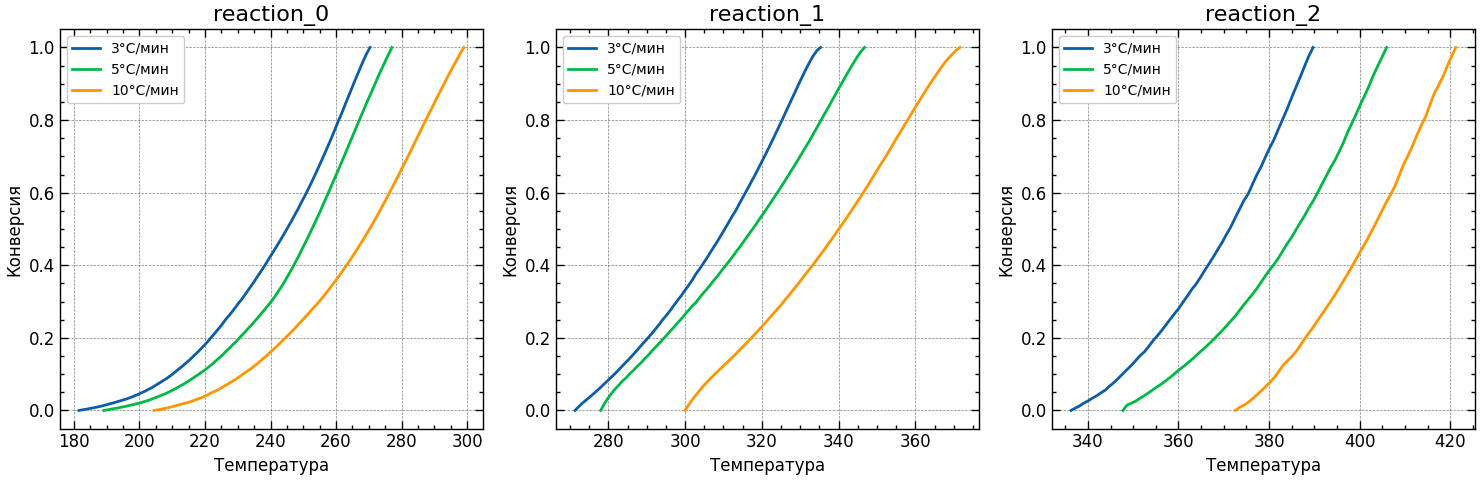

In [7]:
# Получаем уникальные реакции, исключая 'no_reaction', 
# из всех столбцов reactions
all_reactions = pd.unique(
    df[[f'reactions_{rate}' for rate in heating_rates]].values.ravel())
all_reactions = all_reactions[all_reactions != 'no_reaction']

# Отбрасываем последнюю реакцию
all_reactions = all_reactions[:-1]

# Создайте фигуру с несколькими подграфиками
fig, axs = plt.subplots(1, len(all_reactions), 
                        figsize=(5 * len(all_reactions), 5))

# Если есть только одна реакция, axs не будет списком, 
# поэтому обработаем этот случай
if len(all_reactions) == 1:
    axs = [axs]

# Строим графики для каждой реакции
for ax, reaction in zip(axs, all_reactions):
    for rate in heating_rates:
        conversion_col = f'conversion_{rate}'
        reactions_col = f'reactions_{rate}'
        mask = df[reactions_col] == reaction
        if mask.any():
            ax.plot(df.loc[mask].index, df.loc[mask, conversion_col], 
                    label=f'{rate}°С/мин')
    ax.set_title(reaction)
    ax.set_xlabel('Температура', fontsize=BIG_SIZE)
    ax.set_ylabel('Конверсия', fontsize=BIG_SIZE)
    # Настраиваем размер легенды и подписей осей
    ax.legend(loc='upper left', fontsize=MEDIUM_SIZE)
    ax.tick_params(axis='both', which='both', labelsize=BIG_SIZE)

plt.tight_layout()
plt.show()


$$ Прямой~дифференциальный~метод$$
Этот метод использует скорость нагрева, обычно линейную ($\beta$), для повышения температуры. Линейная программа нагрева следует формуле:

$$ T = T_0 + \beta t ~~(2)$$

где $T_0$ - начальная температура, $\beta$ - линейная скорость нагрева (К/мин), и $T$ - температура в момент времени $t$. 

Следующее соотношение можно определить для неизотермических экспериментов:

$$ \frac{{d\alpha}}{{dT}} = \frac{{d\alpha}}{{dt}} \cdot \frac{{dt}}{{dT}} ~~(3)$$

где $\frac{{d\alpha}}{{dT}}$ - неизотермическая скорость реакции; $\frac{{d\alpha}}{{dt}}$ - изотермическая скорость реакции, а $\frac{{dt}}{{dT}}$ - скорость нагрева ($\beta$). 

Дифференциальный закон скорости для реакции первого порядка может быть записан в виде:$$ Скорость~реакции~=~\frac{d[A]}{dt}=-k[A]~~(4)$$ 
Здесь скорость реакции (изменение концентрации $[A]$ в единицу времени) пропорциональна концентрации реагента $[A]$. Отрицательный знак указывает на то, что концентрация $[A]$ с течением времени уменьшается.


Переформулировав уравнение (4), заменим концентрацию реагента $[A]$ на степень превращения $\alpha$: $$ Скорость~реакции~=~\frac{d\alpha}{dt} = k\left(1 - \alpha\right)~~(5)$$

Обобщим уравнение (5), введя функцию $f(\alpha)$, которая отражает специфический характер реакции.$$\frac{d\alpha}{dt} = kf(\alpha)~~(6)$$ 

Уравнение Аррениуса, которое описывает температурную зависимость константы скорости реакции выглядит следующим образом:$$k = A e^{-\frac{E_a}{RT}}~~(7)$$
Путем подстановки уравнения Аррениуса (7) в обобщенный дифференциальный закон скорости (6) получаем:$$\frac{d\alpha}{dt} = A e^{-\frac{E_a}{RT}}f(\alpha)~~(8)$$
Подставляя уравнение (8) в уравнение (3), получим дифференциальную форму неизотермического закона скорости:

$$ \frac{{d\alpha}}{{dT}} = \frac{A}{\beta}  e^{-\frac{{E_a}}{{RT}}}  f(\alpha) ~~(9)$$
Откуда: $$\ln\left(\frac{{da}}{{dT}}\cdot\frac{{1}}{{f(a)}}\right) = \ln \frac{{A}}{{\beta}} - \frac{{E_a}}{{RT}}~~(10)$$

Построение графика левой части (включая модель $f(\alpha)$) относительно $\frac{1}{T}$ позволяет получить энергию активации ($E_a$) и предэкспоненциальный множитель ($A$) из наклона и пересечения с осью $y$ соответственно. Обычно выбирается модель, которая обеспечивает наилучшую линейную аппроксимацию.


In [8]:
# Загружаем данные по кинетическим моделям
models_df = pd.read_csv('nucleation_models.csv')
# models_df.loc[models_df['Model'] == 'Zero-order (F0/R1)', 'Differential Form'] = 'np.full_like(a, 1)'
models_df

,Model,Differential Form,Integral Form
0,Power law (P2),2*a**(1/2),a**(1/2)
1,Power law (P3),3*a**(2/3),a**(1/3)
2,Power law (P4),4*a**(3/4),a**(1/4)
3,Avarami-Erofe’ev (A2),2*(1 - a)*(-np.log(1 - a))**(1/2),(-np.log(1 - a))**(1/2)
4,Avarami-Erofe’ev (A3),3*(1 - a)*(-np.log(1 - a))**(2/3),(-np.log(1 - a))**(1/3)
5,Avarami-Erofe’ev (A4),4*(1 - a)*(-np.log(1 - a))**(3/4),(-np.log(1 - a))**(1/4)
6,Prout–Tompkins (B1),a*(1 - a)*np.log(a/(1 - a)),np.log(a/(1 - a))
7,Contracting area (R2),2*(1 - a)**(1/2),1-(1 - a)**(1/2)
8,Contracting volume (R3),3*(1 - a)**(2/3),1-(1 - a)**(1/3)
9,1-D diffusion (D1),1/2*a,a**2


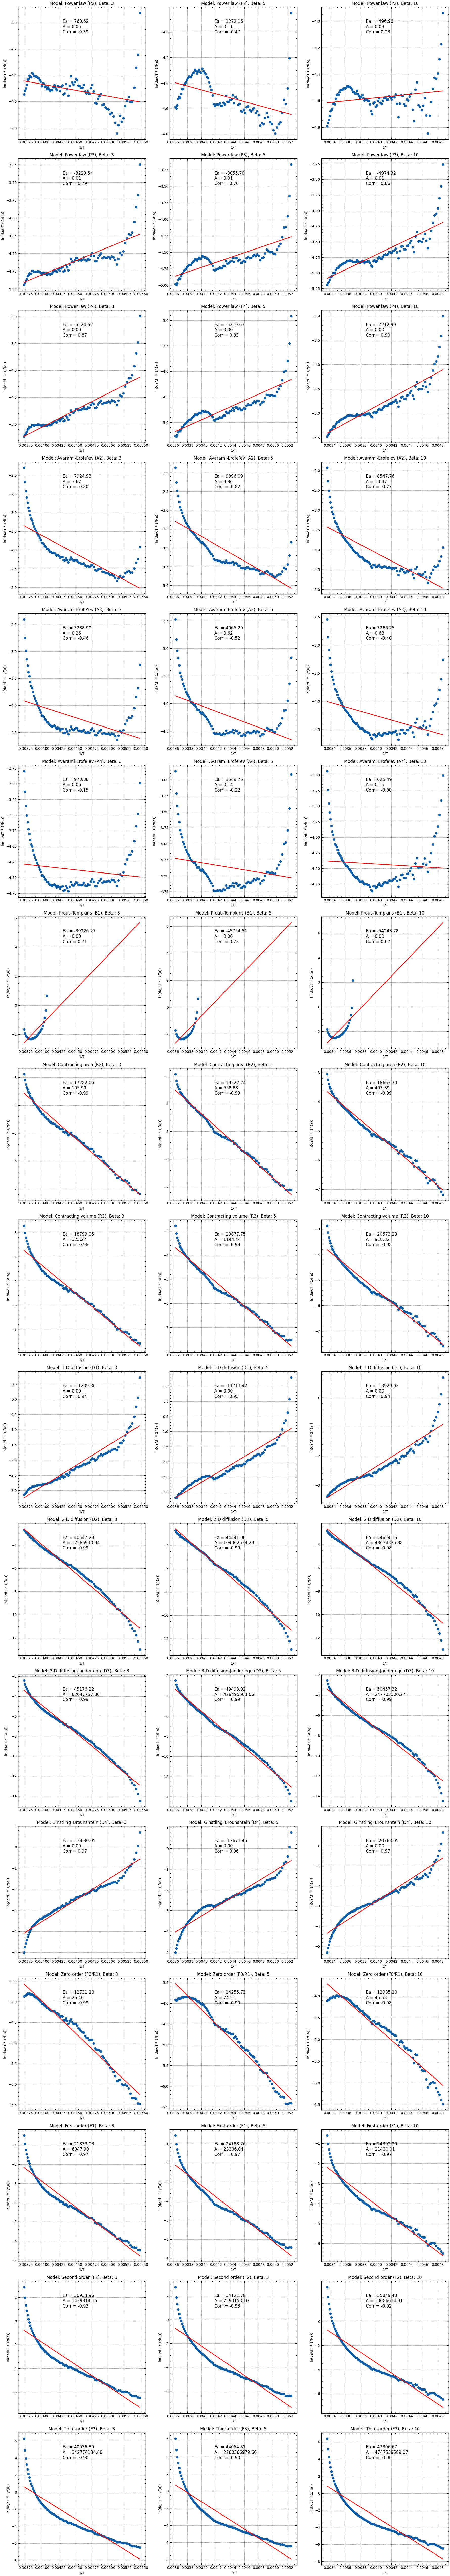

In [9]:
import scipy.stats
import warnings
warnings.filterwarnings('ignore')  # Отключение предупреждений

# Забираем из DataFrame формулы моделей и имена моделей
f_a = models_df['Differential Form'].to_list()
f_names = models_df['Model'].to_list()

index = pd.MultiIndex.from_product([models_df.index, heating_rates], names=['model_index', 'beta'])
models_df = pd.DataFrame(models_df.values.repeat(len(heating_rates), axis=0), index=index, columns=models_df.columns)
models_df['R_corr'] = np.nan
models_df['Ea'] = np.nan
models_df['A'] = np.nan

# Создаем графики для каждой модели и каждого нагрева
fig, axs = plt.subplots(len(f_a), len(heating_rates), figsize=(6*len(heating_rates), 6*len(f_a)))

# Проходимся по каждой модели
for i, model in enumerate(f_a):
    # Проходимся по каждой скорости нагрева
    for j, beta in enumerate(heating_rates):        
        # Создаем запрос для получения данных для каждой реакции
        query = f"reactions_{beta} == 'reaction_0'"
        
        # Получаем температуру и степень превращения для каждого значения beta
        temperature = df.query(query)[beta].index[1:-2] # убираем значение конверсии = 0 и 1
        conversion = df.query(query)[f'conversion_{beta}'].values[1:-2] # убираем значение конверсии = 0 и 1       
        
        # Вычисляем производную степени превращения по температуре
        da_dT = np.gradient(conversion, temperature)
        
        # Выбираем модель и вычисляем значение f(a) для каждого значения степени превращения
        def model_func(a):
            try:
                return eval(model)
            except ZeroDivisionError:
                return np.inf
        
        f_a_val = model_func(conversion)
        
        # Вычисляем левую часть уравнения
        try:
            lhs = np.log(da_dT / f_a_val)
        except ZeroDivisionError:
            lhs = np.inf

        # Удаляем бесконечные значения и NaN из данных
        mask = np.isfinite(lhs) & np.isfinite(1/temperature)
        temperature_clean = (1/temperature)[mask]
        lhs_clean = lhs[mask]
        
        # Строим график
        axs[i, j].plot(1/temperature, lhs, 'o')
        axs[i, j].set_title(f'Model: {f_names[i]}, Beta: {beta}', fontsize=BIG_SIZE)
        axs[i, j].set_xlabel('1/T', fontsize=MEDIUM_SIZE)
        axs[i, j].set_ylabel('ln(da/dT * 1/f(a))', fontsize=MEDIUM_SIZE) 
        
        # Выполняем линейную регрессию
        slope, intercept = np.polyfit(temperature_clean, lhs_clean, 1)
        
        # Строим прямую линию, полученную в результате регрессии
        axs[i, j].plot(1/temperature, slope*(1/temperature) + intercept, 'r-')
        
        # Рассчитываем Ea и A
        Ea = -slope * R
        A = np.exp(intercept) * int(beta)
        
        # Вычисляем коэффициент корреляции Пирсона
        corr_coef, _ = scipy.stats.pearsonr(temperature_clean, lhs_clean)

        # Добавляем значения в DataFrame
        models_df.loc[(i, beta), 'R_corr'] = corr_coef
        models_df.loc[(i, beta), 'Ea'] = Ea
        models_df.loc[(i, beta), 'A'] = A
        
        # Выводим значения Ea, A и корреляции на график
        axs[i, j].text(0.35, 0.8, f'Ea = {Ea:.2f}\nA = {A:.2f}\nCorr = {corr_coef:.2f}', transform=axs[i, j].transAxes, fontsize=BIG_SIZE)        

        # Добавляем размеры шрифта и стиль
        axs[i, j].tick_params(axis='both', which='both', labelsize=MEDIUM_SIZE)


warnings.filterwarnings('default')  # Включаем обратно предупреждения
plt.tight_layout()
plt.show()


In [10]:
models_df.head()

Model Differential Form Integral Form    R_corr  \
model_index beta                                                             
0           3     Power law (P2)        2*a**(1/2)      a**(1/2) -0.387969   
            5     Power law (P2)        2*a**(1/2)      a**(1/2) -0.468042   
            10    Power law (P2)        2*a**(1/2)      a**(1/2)  0.228959   
1           3     Power law (P3)        3*a**(2/3)      a**(1/3)  0.790525   
            5     Power law (P3)        3*a**(2/3)      a**(1/3)  0.704174   

                           Ea         A  
model_index beta                         
0           3      760.617762  0.049591  
            5     1272.155548  0.107242  
            10    -496.961309  0.080924  
1           3    -3229.541575  0.005206  
            5    -3055.702052  0.010170

In [11]:
# Extract 'Model' and 'model_index' from the DataFrame
model_index = models_df.index.get_level_values('model_index')
models = models_df['Model']

# Create a mapping from 'model_index' to 'Model'
model_mapping = {index: f'{model} {index}' for index, model in zip(model_index, models)}

# Replace 'model_index' with the mapping
models_df = models_df.reset_index()
models_df['model_index'] = models_df['model_index'].map(model_mapping)

# Set the index back to 'model_index' and 'beta'
models_df = models_df.set_index(['model_index', 'beta'])

models_df.index[2][1]


'10'

In [12]:
models_df.head()

Model Differential Form Integral Form  \
model_index      beta                                                   
Power law (P2) 0 3     Power law (P2)        2*a**(1/2)      a**(1/2)   
                 5     Power law (P2)        2*a**(1/2)      a**(1/2)   
                 10    Power law (P2)        2*a**(1/2)      a**(1/2)   
Power law (P3) 1 3     Power law (P3)        3*a**(2/3)      a**(1/3)   
                 5     Power law (P3)        3*a**(2/3)      a**(1/3)   

                         R_corr           Ea         A  
model_index      beta                                   
Power law (P2) 0 3    -0.387969   760.617762  0.049591  
                 5    -0.468042  1272.155548  0.107242  
                 10    0.228959  -496.961309  0.080924  
Power law (P3) 1 3     0.790525 -3229.541575  0.005206  
                 5     0.704174 -3055.702052  0.010170

In [13]:
def mins_to_seconds(rate: str) -> int:
    """Преобразует минуты в секунды

    Args:
        rate (str): Строка, содержащая значение в минутах
    Returns:
        int: Преобразованное значение в секундах
    """
    return int(rate) / 60

def get_absolute_T(rate: str, conversion: float, reaction = 'reaction_0') -> np.float64:
    """Получает абсолютное значение температуры для заданной реакции в точке заданной конверсии

    Args:
        rate (str): Значение скорости нагрева
        conversion (float): Значение конверсии
        reaction (str, optional): Название реакции. По умолчанию 'reaction_0'.
    Returns:
        np.float64: Абсолютное значение температуры
    """
    return ((df[df[f'reactions_{rate}'] == reaction][f'conversion_{rate}'] - conversion)\
        .abs().idxmin() + 273.15)


def calculate_OFW_Ea(conversion: float, reaction: str) -> np.float64:
    """Вычисляет активационную энергию методом Озавы-Флинна-Уолла

    Args:
        conversion (float): Значение конверсии
        reaction (str): Название реакции.
    Returns:
        np.float64: Значение активационной энергии
    """
    
    # Вычисляем лонарифм скорости нагрева в секундах
    betta = [np.log(mins_to_seconds(rate)) for rate in heating_rates]

    # Вычисляем значение 1000 / абсолютной температуры для графика
    log_T = [1000 / get_absolute_T(rate, conversion, reaction) for rate in heating_rates]

    # Вычисляем коэффициенты полинома первого порядка
    coefficient = np.polyfit(log_T, betta, 1)

    # Вычисляем активационную энергию
    Ea = coefficient[0] * R / -1.05
    
    return Ea

def calculate_Vyazovkin_Ea(conversion: float, reaction: str) -> np.float64:
    """Вычисляет активационную энергию методом Вязовкина

    Args:
        conversion (float): Значение преобразования
        reaction (str): Название реакции.
    Returns:
        np.float64: Значение активационной энергии
    """
    
    # Вычисляем лонарифм отношения скорости нагрева к квадрату абсолютной температуры
    betta = [np.log(mins_to_seconds(rate) / get_absolute_T(rate, conversion, reaction)**2) 
             for rate in heating_rates]
    
    # Вычисляем значение 1000 / абсолютной температуры для графика
    log_T = [1000 / get_absolute_T(rate, conversion, reaction) for rate in heating_rates]
    
    # Вычисляем коэффициенты полинома первого порядка
    coefficient = np.polyfit(log_T, betta, 1)
    
    # Вычисляем активационную энергию
    Ea = -coefficient[0] * R
    
    return Ea


In [14]:
# создаем пустой список для хранения данных
data = []

# Задаем кол-во точек в которых будет проводиться расчет Ea
VALUE_NUMBER = 25
conversion_values = np.linspace(0.01, 1, VALUE_NUMBER)

# для каждой реакции из списка all_reactions
for reaction in all_reactions:
    # для каждого значения конверсии
    for conversion in conversion_values:
        # вычисляем активационную энергию по методу Вязовкина и Озавы-Флинна-Уолла
        Ea_Vyazovkin = calculate_Vyazovkin_Ea(conversion, reaction)
        Ea_OFW = calculate_OFW_Ea(conversion, reaction)       
        
        # добавляем результаты в список
        data.append({'reaction': reaction, 
                     'conversion': conversion, 
                     'Ea_Vyazovkin': Ea_Vyazovkin, 
                     'Ea_OFW': Ea_OFW})

# преобразуем список в DataFrame
Ea_df = pd.DataFrame(data)

# задаем имена столбцов
Ea_df.columns = ['reaction', 'conversion', 'Ea_Vyazovkin', 'Ea_OFW']

Ea_df

,reaction,conversion,Ea_Vyazovkin,Ea_OFW
0,reaction_0,0.01000,87.789817,91.087998
1,reaction_0,0.05125,103.144231,105.921706
2,reaction_0,0.09250,106.543957,109.280568
3,reaction_0,0.13375,103.788962,106.755817
4,reaction_0,0.17500,105.862455,108.806216
...,...,...,...,...
70,reaction_2,0.83500,132.049375,136.411980
71,reaction_2,0.87625,137.484856,141.612866
72,reaction_2,0.91750,133.225835,137.577808
73,reaction_2,0.95875,133.619079,137.967456


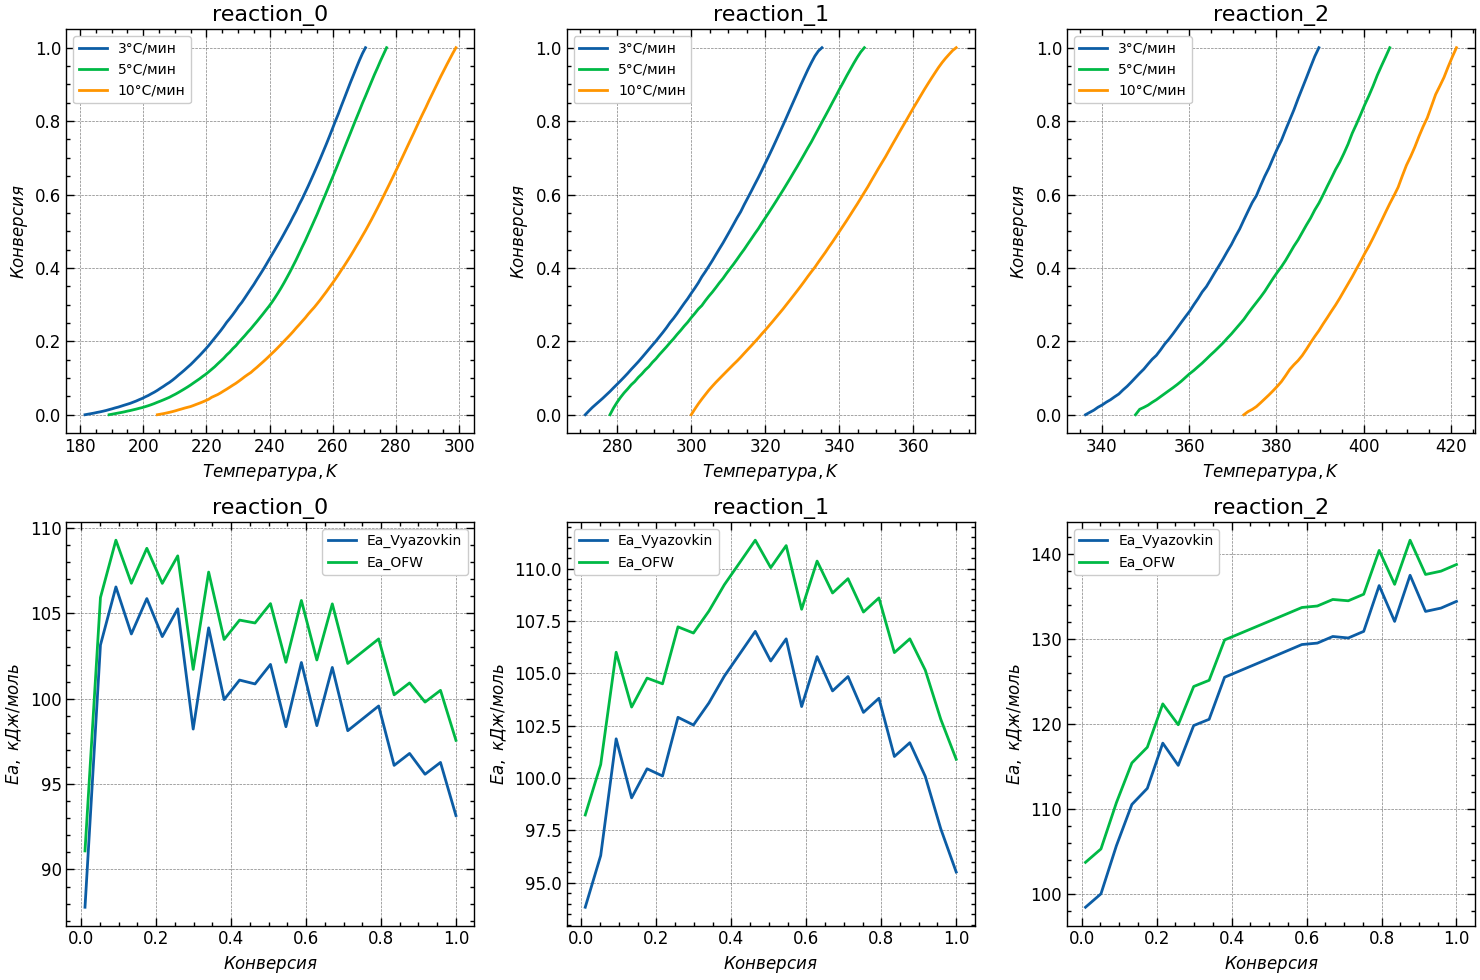

In [15]:
# Создаем фигуру с двумя рядами подграфиков
fig, axs = plt.subplots(2, len(all_reactions), figsize=(5 * len(all_reactions), 10))

# Если есть только одна реакция, axs не будет списком, поэтому обработаем этот случай
if len(all_reactions) == 1:
    axs = np.array([axs])

# Верхний ряд графиков - конверсия от температуры
for ax, reaction in zip(axs[0], all_reactions):
    for rate in heating_rates:
        conversion_col = f'conversion_{rate}'
        reactions_col = f'reactions_{rate}'
        mask = df[reactions_col] == reaction
        if mask.any():
            ax.plot(df.loc[mask].index, df.loc[mask, conversion_col], label=f'{rate}°С/мин')
    ax.set_title(reaction)
    ax.set_xlabel('$Температура, K$', fontsize=BIG_SIZE)
    ax.set_ylabel('$Конверсия$', fontsize=BIG_SIZE)
    ax.legend(loc='upper left', fontsize=MEDIUM_SIZE)
    ax.tick_params(axis='both', which='both', labelsize=BIG_SIZE)

# Нижний ряд графиков - активационная энергия от конверсии
for ax, reaction in zip(axs[1], all_reactions):
    mask = Ea_df['reaction'] == reaction
    if mask.any():
        ax.plot(Ea_df.loc[mask, 'conversion'], Ea_df.loc[mask, 'Ea_Vyazovkin'], label='Ea_Vyazovkin')
        ax.plot(Ea_df.loc[mask, 'conversion'], Ea_df.loc[mask, 'Ea_OFW'], label='Ea_OFW')
    ax.set_title(reaction)
    ax.set_xlabel('$Конверсия$', fontsize=BIG_SIZE)
    ax.set_ylabel('$Ea,~кДж/моль$', fontsize=BIG_SIZE)
    ax.legend(loc='best', fontsize=MEDIUM_SIZE)
    ax.tick_params(axis='both', which='both', labelsize=BIG_SIZE)

plt.tight_layout()
plt.show()



In [16]:
def plot_graphs(conversion, axs, reaction='reaction_0'):
           
    function_names = ['Вязовкин', 'Озава-Флинн-Уолл']
    y_labels = [r'$\ln\left(\frac{\beta}{{T^2}}\right)$', r'$\ln(\beta)$']
    
    # График конверсии от температуры реакции
    for rate in heating_rates:
        conversion_col = f'conversion_{rate}'
        reactions_col = f'reactions_{rate}'
        mask = df[reactions_col] == reaction
        if mask.any():
            axs[0, 0].plot(df.loc[mask].index, df.loc[mask, conversion_col], label=f'{rate}°C/min')
    axs[0, 0].axhline(y=conversion, color='r', linestyle='-')
    axs[0, 0].set_title('$Конверсия~от~температуры$', fontsize=BIG_SIZE)
    axs[0, 0].set_xlabel('$Температура,~°C$', fontsize=MEDIUM_SIZE)
    axs[0, 0].set_ylabel('Конверсия', fontsize=MEDIUM_SIZE)
    axs[0, 0].legend(fontsize=SMALL_SIZE)
    axs[0, 0].tick_params(axis='both', which='both', labelsize=MEDIUM_SIZE)
    
    # График зависимости conversion от 'Ea_Vyazovkin' и 'Ea_OFW'
    mask = Ea_df['reaction'] == reaction
    axs[0, 1].plot(Ea_df.loc[mask, 'conversion'], Ea_df.loc[mask, 'Ea_Vyazovkin'], label='Ea_Vyazovkin')
    axs[0, 1].plot(Ea_df.loc[mask, 'conversion'], Ea_df.loc[mask, 'Ea_OFW'], label='Ea_OFW')
    axs[0, 1].set_xlim([0, 1])
    axs[0, 1].set_ylim([90, 110])
    axs[0, 1].axvline(x=conversion, color='r', linestyle='-')  # Исправлено на axvline()
    axs[0, 1].set_title(r'$E_{a}$ от конверсии', fontsize=BIG_SIZE)
    axs[0, 1].set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
    axs[0, 1].set_ylabel(r'$E_{a}$, кДж/моль', fontsize=MEDIUM_SIZE)
    axs[0, 1].tick_params(axis='both', which='both', labelsize=MEDIUM_SIZE)
    axs[0, 1].legend(fontsize=SMALL_SIZE)  
    
    # График для первой графической области (calculate_Vyazovkin_Ea)
    betta = [np.log(mins_to_seconds(rate) / get_absolute_T(rate, conversion, reaction) ** 2) for rate in heating_rates]
    log_T = [1000 / get_absolute_T(rate, conversion, reaction) for rate in heating_rates]

    axs[1, 0].scatter(log_T, betta, label='data points') 

    coefficient = np.polyfit(log_T, betta, 1)
    y_fit = [coefficient[0] * x + coefficient[1] for x in log_T]
    axs[1, 0].plot(log_T, y_fit, label='fit line')

    axs[1, 0].set_title(function_names[0], fontsize=BIG_SIZE)
    axs[1, 0].set_xlabel('1000/T', fontsize=MEDIUM_SIZE)
    axs[1, 0].set_ylabel(y_labels[0], fontsize=MEDIUM_SIZE)
    axs[1, 0].tick_params(axis='both', which='both', labelsize=MEDIUM_SIZE)
    
    # График для второй графической области (calculate_OFW_Ea)
    betta = [np.log(mins_to_seconds(rate)) for rate in heating_rates]
    log_T = [1000 / get_absolute_T(rate, conversion, reaction) for rate in heating_rates]

    axs[1, 1].scatter(log_T, betta, label='data points') 

    coefficient = np.polyfit(log_T, betta, 1)
    y_fit = [coefficient[0] * x + coefficient[1] for x in log_T]
    axs[1, 1].plot(log_T, y_fit, label='fit line')

    axs[1, 1].set_title(function_names[1], fontsize=BIG_SIZE)
    axs[1, 1].set_xlabel('1000/T', fontsize=MEDIUM_SIZE)
    axs[1, 1].set_ylabel(y_labels[1], fontsize=MEDIUM_SIZE)
    axs[1, 1].tick_params(axis='both', which='both', labelsize=MEDIUM_SIZE)
    
    plt.tight_layout()   
    

In [17]:
# from matplotlib.animation import PillowWriter, FuncAnimation

# fig, axs = plt.subplots(2, 2, figsize=(8, 8))
# frames = np.arange(0.05, 1, 0.01)  # Создаем список со значениями конверсии от 0.05 до 0.99 с шагом 0.01
# # Определяем функцию, которая будет обновлять график на каждом кадре
# def update(frame):
#     # Очистка текущего содержимого графика
#     for ax in axs.flatten():
#         ax.clear()

#     # Строим графики
#     plot_graphs(frame, axs)

# # Создаём анимацию
# ani = FuncAnimation(fig, update, frames=frames)

# # Сохраняем анимацию в файл GIF
# writer = PillowWriter(fps=24)
# ani.save("new_gif.gif", writer=writer)

Путем интегрирования по времени получаем:$$-\ln\frac{[A]}{[A_{0}]}=kt~~(2)$$
Аналогично получим интегральный закона скорости для уравнение через конверсию:$$-\ln\left(1 - \alpha\right) = kt~~(4)$$
Аналогично, обобщим уравнение 4:$$g(\alpha) = kt~~(6)$$
Путем подстановки уравнения Аррениуса (7) в обобщенный интегральный закон скорости (6) получаем:$$g(\alpha) = A e^{-\frac{E_a}{RT}}t~~(10)$$

In [18]:
# Загружаем данные по кинетическим моделям
models_df = pd.read_csv('nucleation_models.csv')
models_df.loc[models_df['Model'] == 'Zero-order (F0/R1)', 'Differential Form'] = 'np.full_like(a, 1)'
models_df

,Model,Differential Form,Integral Form
0,Power law (P2),2*a**(1/2),a**(1/2)
1,Power law (P3),3*a**(2/3),a**(1/3)
2,Power law (P4),4*a**(3/4),a**(1/4)
3,Avarami-Erofe’ev (A2),2*(1 - a)*(-np.log(1 - a))**(1/2),(-np.log(1 - a))**(1/2)
4,Avarami-Erofe’ev (A3),3*(1 - a)*(-np.log(1 - a))**(2/3),(-np.log(1 - a))**(1/3)
5,Avarami-Erofe’ev (A4),4*(1 - a)*(-np.log(1 - a))**(3/4),(-np.log(1 - a))**(1/4)
6,Prout–Tompkins (B1),a*(1 - a)*np.log(a/(1 - a)),np.log(a/(1 - a))
7,Contracting area (R2),2*(1 - a)**(1/2),1-(1 - a)**(1/2)
8,Contracting volume (R3),3*(1 - a)**(2/3),1-(1 - a)**(1/3)
9,1-D diffusion (D1),1/2*a,a**2


$$
\ln \left[ \frac{{d\alpha}}{{dt}} \exp \left( \frac{{E}}{{RT}} \right) \right] = \ln(A) + n \ln \left( \alpha ^{p}  (1 - \alpha) \right), \quad p = \frac{{m}}{{n}} = \frac{{\alpha_m}}{{1 - \alpha_m}}
$$


In [19]:
# Создаём новый столбец 'reaction_integral', в котором будем хранить
# интеграл реальных данных конверсии от температуры
Ea_df['reaction_integral'] = Ea_df.groupby('reaction')['conversion'].cumsum()

# Получаем все уникальные реакции из Ea_df
# Мы будем использовать эти реакции для того, чтобы создать отдельные столбцы для каждой модели для каждой реакции
reactions = Ea_df['reaction'].unique()

# Запускаем цикл по каждой модели из model_df и создаем новый столбец для каждой из них.
# Мы берем формулу из столбца 'Integral Form' для каждой модели и применяем ее к значениям конверсии в Ea_df.
for i in models_df.index:
    model = models_df.loc[i, 'Model'] # название текущей модели
    formula = models_df.loc[i, 'Integral Form'] # формула интегральной формы текущей модели
    
    # Функция для применения формулы к каждой строке в Ea_df
    # Здесь мы просто подставляем значение конверсии в формулу и возвращаем результат
    def apply_formula(row):
        a = row['conversion'] # значение конверсии для текущей строки
        
        # Проверка, чтобы избежать деления на ноль и log(0)
        if a == 0 or a == 1:
            return np.nan
        
        # Вычисление формулы с учетом значения конверсии
        try:
            return eval(formula)
        except ZeroDivisionError: # обрабатываем ошибки, связанные с делением на ноль
            return np.nan
        except ValueError: # обрабатываем ошибки, связанные со значениями, для которых функция log не определена
            return np.nan
    
    # Запускаем цикл по каждой реакции и применяем функцию apply_formula
    # Это создаст новый столбец в Ea_df для каждой реакции для текущей модели
    for reaction in reactions:
        mask = Ea_df['reaction'] == reaction # создаем маску для выбора только строк с текущей реакцией
        Ea_df.loc[mask, model] = Ea_df.loc[mask].apply(apply_formula, axis=1) # применяем функцию к строкам с текущей реакцией


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Список для хранения результатов
results = []

# Обходим все модели и вычисляем статистические метрики
for model in models_df['Model']:
    # Проверяем, есть ли столбец модели в Ea_df
    if model in Ea_df.columns:
        y_true = Ea_df['reaction_integral']
        y_pred = Ea_df[model]
        
        # Удаляем строки с пропущенными значениями
        mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        
        # Вычисляем статистические метрики
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        r = np.corrcoef(y_true, y_pred)[0, 1]
        
        # Добавляем результаты в список
        results.append([model, rmse, mae, r2, r])

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'MAE', 'R^2', 'R'])

# Выводим результаты
results_df


KeyboardInterrupt: 

In [ ]:
# Сортировка results_df по столбцу 'RMSE' в возрастающем порядке и выбор первых трех строк
best_models_df = results_df.sort_values(by='RMSE').head(3)

# Получение названий лучших моделей
best_models = best_models_df['Model'].values

# Filter data to only include 'reaction_0'
reaction_0_data = Ea_df[Ea_df['reaction'] == 'reaction_0']

fig = go.Figure()

# Добавление трасс для каждой из лучших моделей
for model in best_models:
    fig.add_trace(go.Scatter(x=reaction_0_data['conversion'], 
                             y=reaction_0_data[model], 
                             mode='lines', 
                             name=model))

# Добавление трассы для 'reaction_integral'
fig.add_trace(go.Scatter(x=reaction_0_data['conversion'], 
                         y=reaction_0_data['reaction_integral'], 
                         mode='lines', 
                         name='Experimental Data'))

fig.update_layout(title='Best Models and Experimental Data vs Conversion for reaction_0',
                  xaxis_title='Conversion',
                  yaxis_title='Model Outputs and Reaction Integral',
                  autosize=False,
                  width=800,
                  height=500)

fig.show()


In [ ]:
g_a = df[df['reactions_3'] == 'reaction_0']['conversion_3']

g_a


temperature
181.55357    0.000000
182.50849    0.001489
183.46340    0.002943
184.41832    0.004461
185.37323    0.006261
               ...   
266.54101    0.925180
267.49592    0.945804
268.45084    0.965721
269.40575    0.984148
270.36067    1.000000
Name: conversion_3, Length: 94, dtype: float64